# Package Imports & Data Reading

In [ ]:
# import any needed libraries
import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree

In [2]:
# Read in the data
MLBData = pd.read_csv("MLBData.csv")
# Make sure pitch types are correct
MLBData = MLBData[MLBData["pitch_type"].isin(["CH", "CU", "SL", "FF", "KC", "SI", "FS", "FA", "EP", "FC", "KN", "FT", "SC"])]

In [3]:
# Convert the pfx_x and pfx_z columns into HorzBreak and InducedVertBreak
# Scaling both columns by 12 results in their output being in inches, and multiplying pfx_x by -1
# makes the data be oriented from behind the pitcher
MLBData["HorzBreak"], MLBData["InducedVertBreak"] = MLBData["pfx_x"] * -12, MLBData["pfx_z"] * 12

# Change the order of names from last, first to first last
MLBData.player_name=MLBData.player_name.str.split(', ').map(lambda x : ' '.join(x[::-1]))

# change name of first column in order to proper name
MLBData.rename(columns = {'Unnamed: 0': 'row_number'}, inplace = True)

In [4]:
# observe data structure
MLBData.head()

MLBData["delta_run_exp"].describe()


count    1.719214e+06
mean     3.652832e-06
std      2.428943e-01
min     -1.538000e+00
25%     -6.700000e-02
50%     -1.800000e-02
75%      3.800000e-02
max      3.653000e+00
Name: delta_run_exp, dtype: float64

In [5]:
# For every outing that a pitcher has, count the number of various fastball types that they threw and the average velo and movement of those pitches
primaryFastball = MLBData[MLBData["pitch_type"].isin(["FF", "SI", "FC", "FT"])].groupby(["game_date", "player_name", "pitch_type"]).agg({"pitch_number":'size', 'release_speed':'mean', 'InducedVertBreak':'mean', "HorzBreak":'mean'}).reset_index()
# Rename columns
primaryFastball.rename(columns = {'pitch_number':'nPitches', 'release_speed':'meanVelo', 'InducedVertBreak':"meanIVB", 'HorzBreak':'meanHB', 'pitch_type':"primaryFB"}, inplace = True)
# For each outing, select the fastball thrown most often
primaryFastball = primaryFastball[primaryFastball["nPitches"] == primaryFastball.groupby(["game_date", "player_name"])["nPitches"].transform(max)]

primaryFastball.head()

game_date       player_name primaryFB  nPitches   meanVelo    meanIVB  \
1  2020-07-23      Adam Kolarek        SI         8  87.887500  -2.280000   
2  2020-07-23  Brusdar Graterol        SI         6  99.316667   8.400000   
4  2020-07-23    Caleb Ferguson        FF         4  94.950000  16.560000   
5  2020-07-23      Conner Menez        FF        11  92.218182  16.952727   
6  2020-07-23      Dany Jimenez        FF        13  93.300000  16.338462   

      meanHB  
1 -17.340000  
2  14.260000  
4  -5.400000  
5  -4.625455  
6   0.230769

In [6]:
# Join the data onto the original dataset
MLBData = pd.merge(MLBData, primaryFastball, on = ["game_date", "player_name"])

In [7]:
# Calculate velo and movement differences
MLBData["velo_diff"], MLBData["vmov_diff"], MLBData["hmov_diff"] = MLBData["release_speed"] - MLBData["meanVelo"], MLBData["InducedVertBreak"] - MLBData["meanIVB"], MLBData["HorzBreak"] - MLBData["meanHB"]

# Calculate arm angle for a given pitch
MLBData["armAngle"] = np.arctan2((MLBData["release_pos_z"] - 4.2), MLBData["release_pos_x"]) * 180/np.pi - 90
# Assign a textual descriptor to the arm slot for each pitch
MLBData["armSlot"] = np.where(abs(MLBData["armAngle"]) < 30, 'Overhand',
                             np.where(abs(MLBData["armAngle"]) < 70, 'Three-Quarters',
                             np.where(abs(MLBData["armAngle"]) < 90, 'Sidearm', 'Submarine')))
MLBData.head()



row_number    X pitch_type   game_date  release_speed  release_pos_x  \
0           1  195         SL  2022-11-05           89.2          -0.06   
1           2  202         FF  2022-11-05           93.9          -0.18   
2           3  212         FF  2022-11-05           93.0          -0.09   
3           4  216         SL  2022-11-05           88.1          -0.15   
4           5  227         SL  2022-11-05           89.0          -0.25   

   release_pos_z   player_name  batter  pitcher  ... primaryFB nPitches  \
0           6.14  Ryan Pressly  592206   519151  ...        FF        2   
1           5.94  Ryan Pressly  547180   519151  ...        FF        2   
2           5.97  Ryan Pressly  592663   519151  ...        FF        2   
3           6.03  Ryan Pressly  656555   519151  ...        FF        2   
4           6.06  Ryan Pressly  656555   519151  ...        FF        2   

   meanVelo  meanIVB  meanHB  velo_diff  vmov_diff hmov_diff  armAngle  \
0     93.45     19.2    3.18      -4.25     -14.76     -8.10  1.771470   
1     93.45     19.2    3.18       0.45      -0.36      0.78  5.906141   
2     93.45     19.2    3.18      -0.45       0.36     -0.78  2.910838   
3     93.45     19.2    3.18      -5.35     -16.68    -10.50  4.685900   
4     93.45     19.2    3.18      -4.45     -13.44     -7.98  7.655167   

    armSlot  
0  Overhand  
1  Overhand  
2  Overhand  
3  Overhand  
4  Overhand  

[5 rows x 106 columns]

[(-5.0, 5.0)]

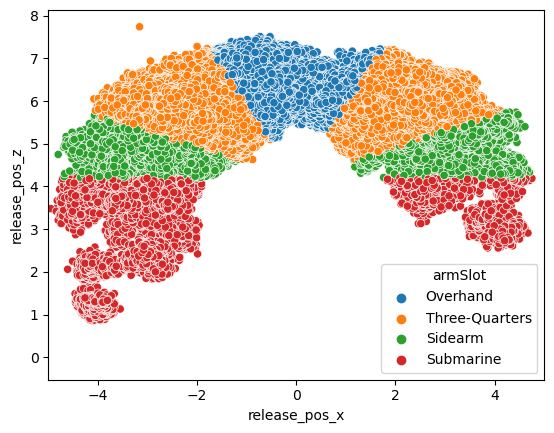

In [8]:
# Plot all of the arm angles in the dataset
armAnglePlot = sns.scatterplot(x = "release_pos_x", y = "release_pos_z", data = MLBData, hue = "armSlot")
armAnglePlot.set(xlim = (-5, 5))

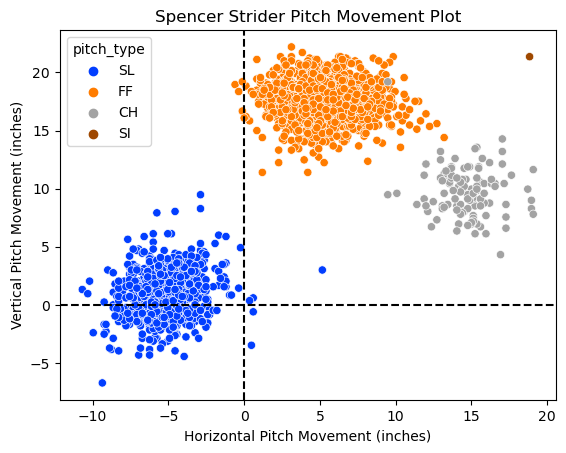

In [9]:
# Creates a plot for a given player that shows all of their individual pitch movements
def playerMovementPlot(playerName):
    palette_colors = sns.color_palette("bright")
    palette_dict = {pitch_type: color for pitch_type, color in zip(MLBData.pitch_type.unique(), palette_colors)}
    playerData = MLBData[MLBData["player_name"] == playerName]
    # Create a scatter plot for a pitcher's pitch movement colored by pitch type
    pitchPlot = sns.scatterplot(x = "HorzBreak", y = "InducedVertBreak", data = playerData, hue = "pitch_type", palette=palette_dict)
    pitchPlot.set(xlabel = "Horizontal Pitch Movement (inches)",
                 ylabel = "Vertical Pitch Movement (inches)",
                 title = playerName + " Pitch Movement Plot")
    pitchPlot.axhline(0, linestyle = '--', color = 'black')
    pitchPlot.axvline(0, linestyle = '--', color = 'black')
    
    
    
playerMovementPlot("Spencer Strider")

In [10]:
# Included features within the model
selectedFeatures = ["release_speed", "InducedVertBreak", "HorzBreak", "armAngle", "release_spin_rate", "release_extension", "spin_axis", "velo_diff", "vmov_diff", "hmov_diff", "delta_run_exp"]

# Drop any missing values from the key features
MLBData.dropna(subset = selectedFeatures, inplace=True)

# Reduce dataset to just key features
MLBDataSelected = MLBData[selectedFeatures].dropna()

#MLBDataSelected.head()

np.random.seed(36)

# Split the data into train/test split
train, test = train_test_split(MLBDataSelected, test_size=0.25)
trainLabel, testLabel = train["delta_run_exp"], test["delta_run_exp"]

# Drop target variable
train, test = train.drop("delta_run_exp", axis = 1), test.drop("delta_run_exp", axis = 1)

# Load the data to be able to be read by xgboost
dtrain = xgb.DMatrix(train, label=trainLabel)
dtest = xgb.DMatrix(test, label=testLabel)
dtotal = xgb.DMatrix(MLBDataSelected.drop("delta_run_exp", axis = 1), MLBDataSelected["delta_run_exp"])

[0]	train-rmse:0.51119	eval-rmse:0.51152
[1]	train-rmse:0.47203	eval-rmse:0.47242
[2]	train-rmse:0.43775	eval-rmse:0.43820
[3]	train-rmse:0.40788	eval-rmse:0.40840
[4]	train-rmse:0.38197	eval-rmse:0.38256
[5]	train-rmse:0.35961	eval-rmse:0.36028
[6]	train-rmse:0.34044	eval-rmse:0.34117
[7]	train-rmse:0.32407	eval-rmse:0.32487
[8]	train-rmse:0.31018	eval-rmse:0.31104
[9]	train-rmse:0.29845	eval-rmse:0.29938
[10]	train-rmse:0.28861	eval-rmse:0.28959
[11]	train-rmse:0.28037	eval-rmse:0.28141
[12]	train-rmse:0.27353	eval-rmse:0.27461
[13]	train-rmse:0.26785	eval-rmse:0.26898
[14]	train-rmse:0.26316	eval-rmse:0.26433
[15]	train-rmse:0.25930	eval-rmse:0.26050
[16]	train-rmse:0.25613	eval-rmse:0.25736
[17]	train-rmse:0.25353	eval-rmse:0.25479
[18]	train-rmse:0.25141	eval-rmse:0.25269
[19]	train-rmse:0.24967	eval-rmse:0.25098
[20]	train-rmse:0.24826	eval-rmse:0.24958
[21]	train-rmse:0.24711	eval-rmse:0.24845
[22]	train-rmse:0.24617	eval-rmse:0.24753
[23]	train-rmse:0.24541	eval-rmse:0.24678
[2

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

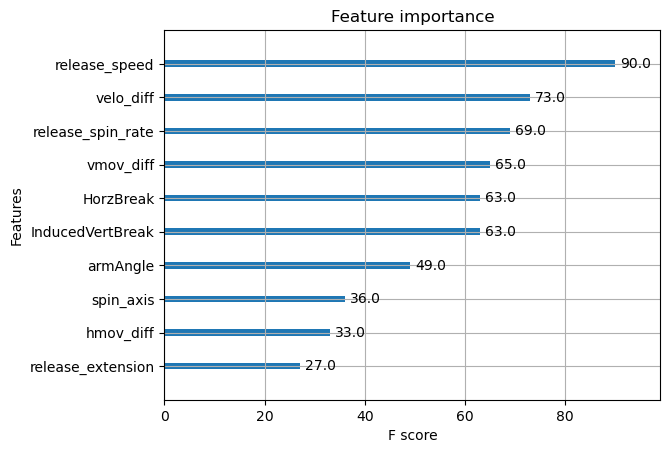

In [11]:
# Create parameters for model training, still need to do random grid search and cv to improve model
param = {'max_depth': 4, 'eta': 0.1, 'objective': 'reg:squarederror', "colsample_bytree" : 0.8, "min_child_weight": 1, "subsample":1}
param['nthread'] = 8

evallist = [(dtrain, 'train'), (dtest, 'eval')]

num_round = 40
# train model
model = xgb.train(param, dtrain, num_round, evals = evallist, early_stopping_rounds = 10)
# plot variable importance
xgb.plot_importance(model)

In [12]:
# Create predictions for the whole dataset
predictions = model.predict(dtotal)

MLBData["expected_run_value"] = predictions

MLBData["expected_run_value"].describe()

# Create the grouping variable so pitches are all graded compared to similar pitch types
MLBData["grouped_pitch_type"] = np.where(MLBData["pitch_type"].isin(["FF", "FA", "FT", "SI"]), "Fastball",
                                        np.where(MLBData["pitch_type"].isin(["CU", "KC", "SL", "EP", "KN"]), "Breaking Ball", 
                                                np.where(MLBData["pitch_type"].isin(["FS", "CH", "SC"]), "Off Speed",
                                                        np.where((MLBData["pitch_type"].isin(["FC"])) & (MLBData["primaryFB"] == "FC"), "Fastball", "Breaking Ball"))))

# Convert predictions from normal distribution to 20-80 scale, another normal distribution
# The mean and sd by group variables are used to calculate the z score of a given pitch
# We then multiply by 10 to set the standard deviation to 10 and add 50 to set the mean to 50
MLBData["meanByGroup"] = MLBData.groupby(["grouped_pitch_type"])["expected_run_value"].transform("mean") * -1
MLBData["sdByGroup"] = MLBData.groupby(["grouped_pitch_type"])["expected_run_value"].transform("std")
MLBData["stuffGrade"] = (-MLBData.expected_run_value - (MLBData.meanByGroup))/(MLBData.sdByGroup) * 10 + 50
# Some pitches receive outlier grades, so we push them back to the highest possible values on the scale
MLBData["stuffGrade"] = np.where(MLBData["stuffGrade"] < 20, 20, np.where(MLBData["stuffGrade"] > 80, 80, MLBData["stuffGrade"]))

# Checking to make sure that the mean of each group is ~ 50
MLBData.groupby(["grouped_pitch_type"]).agg({"stuffGrade":"mean"})

stuffGrade
grouped_pitch_type            
Breaking Ball        50.054432
Fastball             49.957054
Off Speed            50.062462

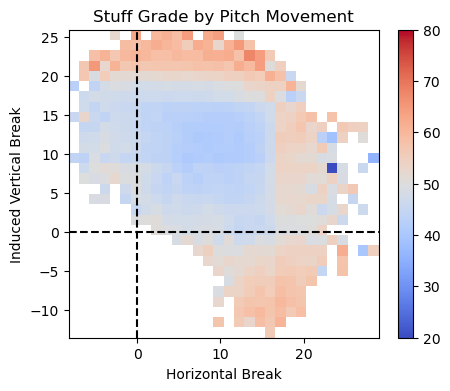

In [75]:
# Filter down the dataset to just fastballs
RHPFastballs = MLBData[MLBData["pitch_type"].isin(["FF", "SI"])]

# Filter down the fastballs to just pitches thrown by RHP
RHPFastballs = RHPFastballs[RHPFastballs["p_throws"] == "R"]

# Filter the data down to just RHP fastballs thrown between 90-92 MPH
RHPFastballs = RHPFastballs[RHPFastballs["release_speed"].between(90,92)]
RHPFastballs.head()

# This plot will bin the horizontal and vertical pitch movement and find the mean of the pitch grade for the bin
# Red indicates a higher grade (better pitch) and blue indicates a lower grade (worse pitch)
counts, xbins, ybins = np.histogram2d(RHPFastballs["InducedVertBreak"], RHPFastballs["HorzBreak"], bins = (30,30))
sums, _, _ = np.histogram2d(RHPFastballs["InducedVertBreak"], RHPFastballs["HorzBreak"], weights = RHPFastballs["stuffGrade"], bins = (xbins, ybins))

fig, ax = plt.subplots(ncols = 1, figsize = (5,4))

with np.errstate(divide='ignore', invalid='ignore'):  # suppress possible divide-by-zero warnings
    m = ax.pcolormesh(ybins, xbins, sums / counts, cmap='coolwarm', vmin = 20, vmax = 80)
    
plt.colorbar(m, ax=ax)
plt.xlabel("Horizontal Break")
plt.ylabel("Induced Vertical Break")
plt.title("Stuff Grade by Pitch Movement")
plt.axhline(0, linestyle = '--', color = 'black')
plt.axvline(0, linestyle = '--', color = 'black')

In [29]:
#RHPFastballs[RHPFastballs["expected_run_value"] == RHPFastballs["expected_run_value"].max()]
# We can aggregate the data by pitcher to see which pitch receives the highest grades on average and some of their pitch characteristics
# This table is just fastballs, but the next table will be all pitch types

bestFBs = RHPFastballs.groupby(["player_name", "pitch_type"]).agg({"stuffGrade":"mean", "release_speed":"mean", "InducedVertBreak":"mean", "HorzBreak":"mean", "des":"count"}).reset_index()
bestFBs.rename(columns = {'des': 'nPitches'}, inplace = True)
bestFBs = bestFBs[bestFBs["nPitches"] > 500]
bestFBs.sort_values(by = ["stuffGrade"], ascending = False).head(25)
#RHPFastballs["stuffGrade"].describe()

player_name pitch_type  stuffGrade  release_speed  \
436      Felix Bautista         FF   73.540079      99.152961   
1237       Trevor Bauer         FF   69.518897      93.698312   
886           Matt Bush         FF   68.631157      97.139961   
1027     Pete Fairbanks         FF   68.065789      97.716941   
826       Liam Hendriks         FF   67.752787      97.376000   
1108       Ryan Helsley         FF   66.604543      98.510979   
469         Gerrit Cole         FF   66.057453      97.530853   
383         Dylan Cease         FF   65.821012      96.860557   
204          Chad Green         FF   65.475723      95.538719   
921      Michael Kopech         FF   65.367529      95.810636   
1179    Spencer Strider         FF   65.359398      98.142750   
549        Jacob deGrom         FF   64.614360      98.936491   
1280        Tyler Wells         FF   64.455784      94.240315   
1204      Tanner Rainey         FF   64.360772      96.621187   
578     James Karinchak         FF   63.560195      95.610694   
529     J.P. Feyereisen         FF   63.249537      92.916861   
765    Justin Verlander         FF   63.157823      95.069186   
695       Jordan Romano         FF   63.136646      97.219787   
1272      Tyler Glasnow         FF   63.111984      97.184027   
380          Dustin May         SI   63.012347      97.897883   
687   Jonathan Loaisiga         SI   62.954263      98.029180   
732          Josh Sborz         FF   62.931928      96.771324   
53           Alex Reyes         FF   61.895139      96.927787   
982        Nick Pivetta         FF   61.780013      94.048738   
508       Hunter Greene         FF   61.611195      98.904996   

      InducedVertBreak  HorzBreak  nPitches  
436          19.675263   7.266908       608  
1237         19.971994   9.761093      1244  
886          18.964211   6.752749       513  
1027         18.264505  -0.294505      1092  
826          18.819459   6.737647      1700  
1108         17.524501   3.055663      1093  
469          18.135407  11.256979      4019  
383          18.339715   3.869136      3159  
204          19.141068   4.836641      1405  
921          18.610020   9.841551      2012  
1179         17.735819   5.106817      1593  
549          16.708070   8.604632      1710  
1280         19.901523   5.159901      1208  
1204         18.077871   8.090358       977  
578          19.285836   4.025269      1412  
529          20.632374   5.022412       771  
765          19.327519   9.563566      1548  
695          18.081675   5.371330      1218  
1272         17.509295   1.529765      1659  
380           7.944956  18.582217       803  
687          11.547678  15.942446      1292  
732          18.973414   6.491519       823  
53           17.784759   5.463095       601  
982          20.186084   5.157451      3248  
508          16.020254  11.713158      1181

In [54]:
#MLBData[MLBData["expected_run_value"] == MLBData["expected_run_value"].max()]

# This table is looking at all pitch types for all pitchers that have been thrown at least 250 times over our 3 year sample

bestPitches = MLBData.groupby(["player_name", "pitch_type"]).agg({"stuffGrade":"mean", "release_speed":"mean", "InducedVertBreak":"mean", "HorzBreak":"mean", "release_spin_rate":"mean", "des":"count"}).reset_index()
bestPitches.rename(columns = {'des': 'nPitches'}, inplace = True)
bestPitches = bestPitches[bestPitches["nPitches"] > 250]

# This function will return all of the pitch types for a given player along with their grades and characteristics
def playerGrades(playerName):
    return bestPitches[bestPitches["player_name"] == playerName].sort_values(by = ["stuffGrade"], ascending = False)

bestPitches.sort_values(by = ["stuffGrade"], ascending = False).head(25)
#RHPFastballs["stuffGrade"].describe()



player_name pitch_type  stuffGrade  release_speed  \
1435        Dustin May         CU   74.014314      86.218750   
3175        Matt Brash         SL   73.882999      87.016971   
1327    Devin Williams         CH   73.588792      83.641433   
1600    Felix Bautista         FF   73.540079      99.152961   
3354     Miguel Castro         SL   72.442468      85.900123   
2862        Kyle Crick         SL   71.147745      78.894606   
4480      Trevor Bauer         FF   69.518897      93.698312   
2298         Joe Kelly         KC   68.662184      87.541218   
3178         Matt Bush         FF   68.631157      97.139961   
3670    Pete Fairbanks         FF   68.065789      97.716941   
1154       Daniel Bard         SL   67.938288      87.608909   
4483      Trevor Bauer         SL   67.882190      80.685767   
2954     Liam Hendriks         FF   67.752787      97.376000   
4391      Tejay Antone         CU   67.683431      79.567636   
828     Charlie Morton         CU   67.193399      80.719970   
3313      Michael King         SL   67.128943      81.563488   
4518  Trevor Rosenthal         FF   67.123303      98.050327   
106      Adam Ottavino         SL   66.947490      80.828401   
1448       Dylan Cease         SL   66.892225      86.581429   
3973      Ryan Helsley         FF   66.604543      98.510979   
374    Aroldis Chapman         FF   66.405422      97.940702   
1716       Gerrit Cole         FF   66.057453      97.530853   
3690        Phil Maton         CU   66.029448      75.439239   
1445       Dylan Cease         FF   65.821012      96.860557   
916     Chris Stratton         CU   65.731336      80.447757   

      InducedVertBreak  HorzBreak  release_spin_rate  nPitches  
1435         -5.396591 -13.738977        3160.511364       352  
3175          0.183603 -15.131279        2893.391645       383  
1327         -3.321502  17.992464        2787.862799      1465  
1600         19.675263   7.266908        2340.735197       608  
3354          1.456471 -10.252059        2925.890931       816  
2862          0.537261 -21.165809        3194.047718       482  
4480         19.971994   9.761093        2781.580386      1244  
2298         -9.050726  -8.701546        2907.837237       854  
3178         18.964211   6.752749        2536.048733       513  
3670         18.264505  -0.294505        2431.648352      1092  
1154          2.237127  -8.216618        2849.050000      1100  
4483         -2.616488 -17.342551        2956.212569       541  
2954         18.819459   6.737647        2409.547059      1700  
4391        -10.605818 -17.693673        2984.905455       275  
828          -9.510167 -16.258103        3044.140945      2689  
3313          0.909973 -18.131444        2742.400545       367  
4518         18.095686   5.745098        2460.480392       306  
106           0.821480 -18.265394        2738.856802      1257  
1448         -0.606950  -5.401575        2845.691506      2590  
3973         17.524501   3.055663        2588.995425      1093  
374          18.096526  -4.280526        2380.108772      1140  
1716         18.135407  11.256979        2451.727793      4019  
3690         -9.231181 -19.297008        2991.405512       762  
1445         18.339715   3.869136        2524.160177      3159  
916          -8.351240 -15.814037        3146.245383       758

In [56]:
playerGrades("Graham Ashcraft").head(10)

player_name pitch_type  stuffGrade  release_speed  InducedVertBreak  \
1741  Graham Ashcraft         SL   61.334864      85.791429         -2.798242   
1739  Graham Ashcraft         FC   53.940315      97.265083          9.467031   
1740  Graham Ashcraft         SI   46.444777      97.067347          6.399534   

      HorzBreak  release_spin_rate  nPitches  
1741 -11.025231        2706.729670       455  
1739  -0.600285        2383.301663       842  
1740   9.672420        2185.469388       343

In [16]:
#MLBData[MLBData["expected_run_value"] == MLBData["expected_run_value"].max()]

# This table is the highest graded pitchers with a minimum of 500 pitches thrown in total, regardless of pitch type

bestPitchers = MLBData.groupby(["player_name"]).agg({"stuffGrade":"mean", "des":"count"}).reset_index()
bestPitchers.rename(columns = {'des': 'nPitches'}, inplace = True)
bestPitchers = bestPitchers[bestPitchers["nPitches"] > 500]
bestPitchers.sort_values(by = ["stuffGrade"], ascending = False).head(25)
#RHPFastballs["stuffGrade"].describe()

player_name  stuffGrade  nPitches
380      Felix Bautista   67.819584       993
316      Devin Williams   65.361720      2476
752          Matt Brash   64.635423       970
1060       Trevor Bauer   63.971779      2938
795       Miguel Castro   62.987786      2239
275         Daniel Bard   62.856025      2583
701       Liam Hendriks   62.834236      2568
196          Chad Green   62.817211      2088
89      Aroldis Chapman   62.582101      1948
870      Pete Fairbanks   62.551335      1864
1005    Spencer Strider   62.346613      2365
538        Jimmy Nelson   62.147864       518
342         Dylan Cease   62.054692      7198
1087      Tyler Glasnow   61.804199      2993
340          Dustin May   61.720488      1897
408         Gerrit Cole   61.564790      8094
455     J.P. Feyereisen   61.333885      1519
680          Kyle Crick   61.288790       823
1039       Tejay Antone   61.263102      1111
362      Emmanuel Clase   61.171971      2037
941        Ryan Helsley   61.169187      2012
173       Caleb Baragar   61.040522       690
720            Luis Gil   60.784321       615
183        Camilo Doval   60.751881      1622
577   Jonathan Loaisiga   60.670362      2475

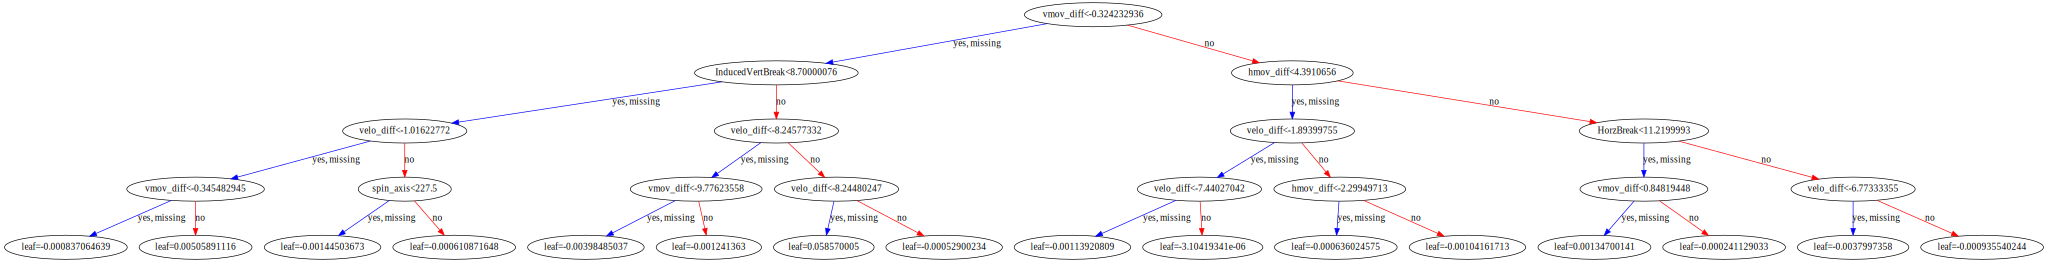

In [82]:
# This shows a given tree within the model, can't see much though
xgb.to_graphviz(model, num_trees=39)

In [ ]:
'''
Here will test how our data will run under a random forest model compared to that of an xgboost model
'''
# Split the data into train/test split
train, test = train_test_split(MLBDataSelected, test_size=0.25)
trainLabel, testLabel = train["delta_run_exp"], test["delta_run_exp"]

# Drop target variable
train, test = train.drop("delta_run_exp", axis=1), test.drop("delta_run_exp", axis=1)

# Fit the random forest model
rf_model = RandomForestRegressor(n_estimators=5, random_state=36) #took forever to run 100 trees by default, so had to lower the number down
rf_model.fit(train, trainLabel)

# Predict using the trained model
predictions = rf_model.predict(test)